In [1]:
import tensorflow as tf
import tensorflow.keras.datasets as tfds
import random
import numpy as np
import matplotlib.pyplot as plt
import keras

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

Using TensorFlow backend.


In [2]:
(X_train,y_train),(X_test,y_test) = tfds.mnist.load_data()

In [3]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [4]:
print(f'shape of training data: {X_train.shape}')
print(f'shape of test data: {X_test.shape}')

shape of training data: (60000, 28, 28)
shape of test data: (10000, 28, 28)


In [5]:
def random_examples():
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        features = random.choices(X_train,k=25)
        plt.imshow(features[i], cmap=plt.cm.binary)
    plt.show()

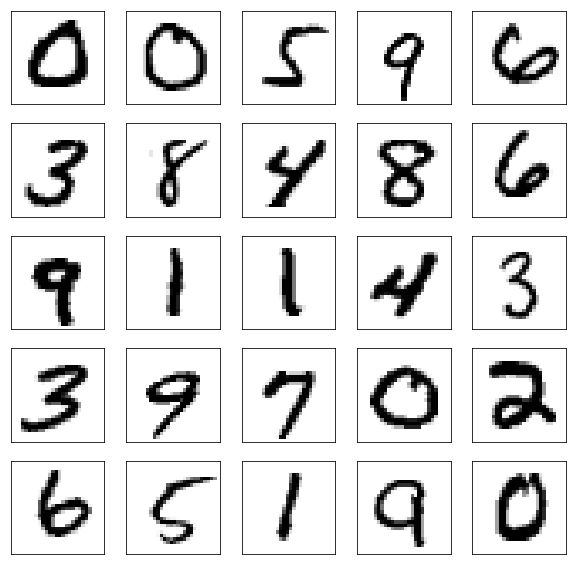

In [6]:
random_examples()

In [7]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [9]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MyModel()

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [12]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [13]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [14]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_ds:
        train_step(images, labels)
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

Epoch 1, Loss: 0.13898929953575134, Accuracy: 95.94332885742188, Test Loss: 0.06014316901564598, Test Accuracy: 98.05999755859375
Epoch 2, Loss: 0.04288076236844063, Accuracy: 98.63999938964844, Test Loss: 0.056220825761556625, Test Accuracy: 98.18999481201172
Epoch 3, Loss: 0.022810783237218857, Accuracy: 99.2699966430664, Test Loss: 0.05165383964776993, Test Accuracy: 98.27999877929688
Epoch 4, Loss: 0.013637910597026348, Accuracy: 99.57333374023438, Test Loss: 0.05822015926241875, Test Accuracy: 98.47000122070312
Epoch 5, Loss: 0.010230041109025478, Accuracy: 99.65666198730469, Test Loss: 0.06349095702171326, Test Accuracy: 98.30999755859375
